In [ ]:
import os
import sys
import random
import gc

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.utils as utils
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

import matplotlib as  mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_json('/content/drive/MyDrive/projects/data-hanmadang/time-series.json')
train_data = torch.tensor(train_df.values).unsqueeze(0)
train_data.shape

torch.Size([1, 305, 3665])

In [ ]:
train_df

,85123A,71053,84406B,84029G,84029E,22752,21730,22633,22632,84879,...,23562,23561,90214F,90214O,90214T,90214U,90214W,90214Z,90089,23843
2010-12-01,0.018212,0.001321,0.001652,0.002313,0.022672,0.000909,0.001239,0.007351,0.009581,0.008920,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-12-02,0.009922,0.003018,0.002729,0.004303,0.004335,0.007032,0.002376,0.004881,0.005395,0.016152,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-12-03,0.001689,0.000000,0.000000,0.000338,0.001351,0.000507,0.000253,0.008616,0.002196,0.002703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-12-05,0.012037,0.000000,0.002006,0.001763,0.001033,0.000486,0.000122,0.004985,0.004560,0.007842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-12-06,0.008348,0.000614,0.000737,0.000246,0.002885,0.000614,0.002148,0.016635,0.017433,0.006998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,0.007677,0.000078,0.000442,0.000468,0.001041,0.001145,0.000104,0.002732,0.001327,0.002836,...,0.000729,0.000625,0.000312,0.000312,0.000312,0.000312,0.000312,0.000312,0.000000,0.000000
2011-12-06,0.001402,0.000000,0.000000,0.000539,0.000287,0.003450,0.000072,0.001078,0.001402,0.008625,...,0.000862,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000862,0.000000
2011-12-07,0.004866,0.000146,0.000000,0.000973,0.001192,0.000292,0.000097,0.000998,0.000633,0.006228,...,0.001800,0.001654,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-08,0.003739,0.000000,0.000000,0.002468,0.000472,0.000871,0.000000,0.001488,0.002033,0.000109,...,0.000762,0.000436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000036,0.000000


In [ ]:
train_data = train_data.to('cuda')

In [ ]:
train_data = train_data.float().reshape(1, -1, 3665)

In [ ]:
train_data.shape

torch.Size([1, 305, 3665])

## Asymmetric Autoencoder
By practical experiment and [architecture of WaveNet](https://arxiv.org/pdf/1609.03499.pdf), pretrained AE outperforms than scratch training.

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, window=9, num_features=3665):
        super(CNNEncoder, self).__init__()
        self.window = window
        self.num_features = num_features

        self.conv = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(self.num_features,
                          self.num_features * 3 // 4 + 1,
                          kernel_size=self.window,
                          padding=(self.window - 1) * 1,
                          dilation=1
                ),
                nn.GELU(),
                nn.Dropout1d(0.1),
            ),
            nn.Sequential(
                nn.Conv1d(self.num_features * 3 // 4 + 1,
                          self.num_features // 2 + 1,
                          kernel_size=self.window,
                          padding=(self.window - 1) * 2,
                          dilation=2
                ),
                nn.GELU(),
                nn.Dropout1d(0.1),
            ),
            nn.Sequential(
                nn.Conv1d(self.num_features // 2 + 1,
                          self.num_features // 4 + 1,
                          kernel_size=self.window,
                          padding=(self.window - 1) * 4,
                          dilation=4
                ),
                nn.GELU(),
                nn.Dropout1d(0.1),
            ),
            nn.Sequential(
                nn.Conv1d(self.num_features // 4 + 1,
                          self.num_features // 8 + 1,
                          kernel_size=self.window,
                          padding=(self.window - 1) * 8,
                          dilation=8
                ),
                nn.GELU(),
            ),
            nn.Sequential(
                nn.Conv1d(self.num_features // 8 + 1,
                          self.num_features // 16 + 1,
                          kernel_size=self.window,
                          padding=(self.window - 1) * 16,
                          dilation=16
                ),
                nn.GELU(),
            ),
            nn.Sequential(
                nn.Conv1d(self.num_features // 16 + 1,
                          self.num_features // 32 + 1,
                          kernel_size=self.window,
                          padding=(self.window - 1) * 32,
                          dilation=32
                ),
                nn.GELU(),
            )]
        )

    def forward(self, x):
        for layer in self.conv:
            x = layer(x)
            x = x[:, :, :-layer[0].padding[0]]
        return x

class CNNDecoder(nn.Module):
    def __init__(self, window=9, num_features=3665):
        super(CNNDecoder, self).__init__()
        self.window = window
        self.num_features = num_features

        self.cnn_decoder = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose1d(self.num_features // 32 + 1,
                                   self.num_features // 8 + 1,
                                   kernel_size=self.window,
                                   padding=self.window // 2
                ),
                nn.GELU(),
            ),
            nn.Sequential(
                nn.ConvTranspose1d(self.num_features // 8 + 1,
                                   self.num_features // 2 + 1,
                                   kernel_size=self.window,
                                   padding=self.window // 2
                ),
                nn.GELU(),
            ),
            nn.Sequential(
                nn.ConvTranspose1d(self.num_features // 2 + 1,
                                   self.num_features,
                                   kernel_size=self.window,
                                   padding=self.window // 2
                ),
                nn.Softmax(dim=-2),
            )]
        )

    def forward(self, x):
        for layer in self.cnn_decoder:
            x = layer(x)
        return x

## SAM Optimizer
[SAM Optimizer](https://arxiv.org/pdf/2010.01412.pdf) helps models learn better than any other optimizer.

In [ ]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

  0%|          | 0/400 [00:00<?, ?it/s]

<Axes: >

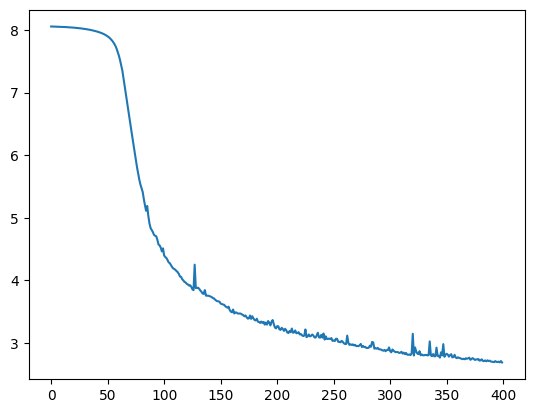

In [ ]:
cnn_encoder = CNNEncoder().to('cuda')
cnn_decoder = CNNDecoder().to('cuda')
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = SAM(list(cnn_encoder.parameters()) + list(cnn_decoder.parameters()), AdamW, lr=1e-5)

loss_lt = []
for epoch in tqdm(range(400)):
    repr = cnn_encoder(train_data.transpose(-1, -2))
    pred = cnn_decoder(repr)
    loss = criterion((train_data.squeeze() + 1e-8).log(), (pred.transpose(-1, -2)).squeeze())
    loss.backward()
    optimizer.first_step(zero_grad=True)

    repr = cnn_encoder(train_data.transpose(-1, -2))
    pred = cnn_decoder(repr)
    loss = criterion((train_data.squeeze() + 1e-8).log(), (pred.transpose(-1, -2)).squeeze())
    loss_lt.append(loss.item())
    loss.backward()
    optimizer.second_step(zero_grad=True)

loss_lt = pd.Series(loss_lt)
loss_lt.plot()

In [ ]:
loss_lt[-10:].mean()

2.698629093170166

In [ ]:
loss_lt[-10:].mean()

2.698629093170166

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, cnn_encoder, hidden_size=196, num_features=3665, num_layers=16):
        super(CNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.num_layers = num_layers

        self.cnn_encoder = cnn_encoder
        self.lstm = nn.LSTM(self.num_features // 32 + 1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, self.num_features // 32 + 1),
            nn.BatchNorm1d(self.num_features // 32 + 1),
            nn.ReLU(),
            nn.Linear(self.num_features // 32 + 1, self.num_features // 8 + 1),
            nn.BatchNorm1d(self.num_features // 8 + 1),
            nn.ReLU(),
            nn.Dropout1d(0.1),
            nn.Linear(self.num_features // 8 + 1, self.num_features // 4 + 1),
            nn.BatchNorm1d(self.num_features // 4 + 1),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.Linear(self.num_features // 4 + 1, self.num_features),
            nn.Softmax(dim=-1)
        )

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to('cuda')
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to('cuda')
        return h0, c0

    def forward(self, input_ts):
        x = self.cnn_encoder(input_ts)
        x = x.transpose(-1, -2)
        h0, c0 = self.init_hidden(x.shape[0])
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
train_data = train_data.squeeze()

In [ ]:
train_tensor = torch.stack([
    train_data[i : i + 256].transpose(-1, -2) for i in range(len(train_data) - 256)
])[:-2]
target_tensor = torch.stack([
    train_data[i + 256] for i in range(len(train_data) - 256)
])[:-2]
train_tensor.shape, target_tensor.shape

(torch.Size([47, 3665, 256]), torch.Size([47, 3665]))

In [ ]:
dataset = TensorDataset(train_tensor, target_tensor)
dataloader = DataLoader(dataset, batch_size=48, shuffle=True)
criterion = nn.KLDivLoss(reduction='batchmean')
model = CNN_LSTM(cnn_encoder).to('cuda')
optimizer = SAM(model.parameters(), AdamW, lr=2e-4)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


1.0832520365715026


<Axes: >

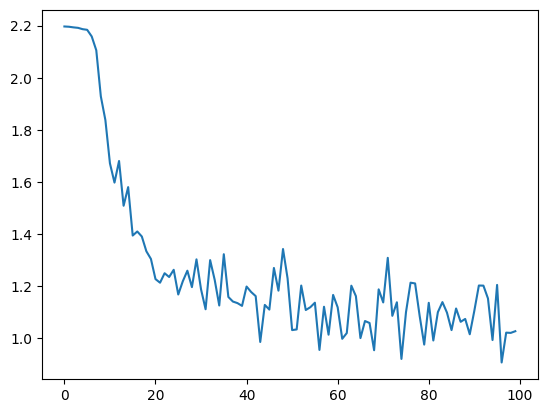

In [ ]:
result_lt = []
model.train()
for epoch in tqdm(range(100)):
    for batch in dataloader:
        x, y = batch
        output = model(x)
        loss = criterion((output + 1e-12).log(), y)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        output = model(x)
        loss = criterion((output + 1e-12).log(), y)
        loss.backward()
        optimizer.second_step(zero_grad=True)
        result_lt.append(loss.item())

result = pd.Series(result_lt)
print(result[-10:].mean())
result.plot()

In [ ]:
train_data.shape

torch.Size([305, 3665])

In [ ]:
model.train()
with torch.no_grad():
    pred_tensor = model(
        torch.stack(
        [train_data[:254].T, train_data[-256:-2].T
         ])
        )
pred_tensor.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([2, 3665])

In [ ]:
model.eval()
with torch.no_grad():
    pred_tensor = model(train_data[-256:-2].T.unsqueeze(0))
pred_tensor.shape

torch.Size([1, 3665])

In [ ]:
val_tensor = train_data[-2].unsqueeze(0)
val_tensor.shape

torch.Size([1, 3665])

In [ ]:
pred_tensor

tensor([[2.0457e-03, 1.2753e-04, 3.5220e-04,  ..., 7.7742e-05, 1.5497e-04,
         1.2930e-05]], device='cuda:0')

In [ ]:
pred = pred_tensor.detach().cpu().numpy()
val = val_tensor.detach().cpu().numpy()

<Axes: >

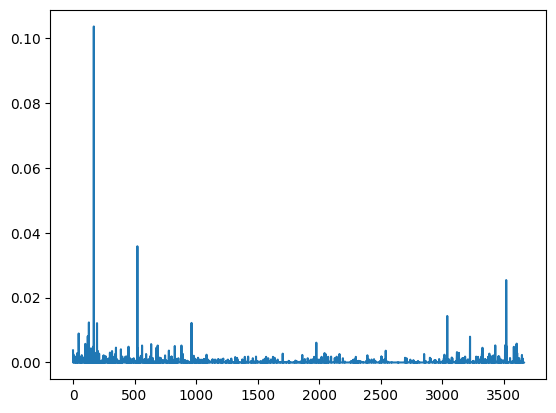

In [ ]:
pd.Series(val[0]).plot.line()

<Axes: >

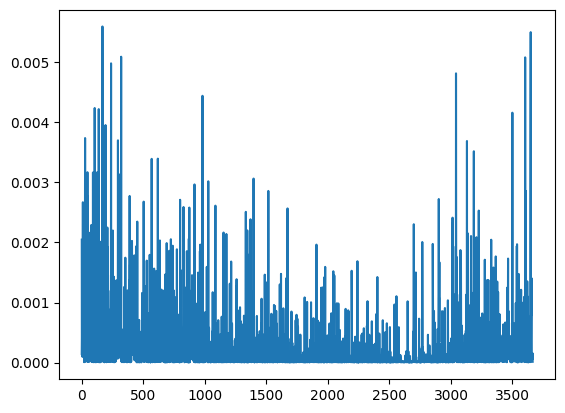

In [ ]:
pd.Series(pred[0]).plot.line()

In [ ]:
jensenshannon(pred[0], val[0])

0.5053034492960778